(gp_ssm)
# GP as state-space models

In [this section](gp_statespace), we described how temporal Gaussian process regression could formulated as a state-space model. This allows reducing the computational cost of prediction from $\mathcal{O}(N^3)$ $\mathcal{O}(N)$. This tutorial illustrates this method on the same building 1298 example as the [GP prediction](gp_prediction) notebook.

It uses the [pySIP](https://github.com/locie/pySIP) library, which has an implementation of temporal GPs along with regular state-space models.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pysip.regressors import Regressor
from pysip.statespace import Matern32, Matern52, Periodic
from pysip.params.prior import Gamma, LogNormal
import arviz as az

We will be building a GP to predict the electricity consumption of [building 1298](building1298) from the [Great Energy Predictor](https://www.kaggle.com/c/ashrae-energy-prediction) Kaggle competition.

In the following block, we are loading the data, filtering out outliers, and saving the meter data `m0` into a normalized variable `y`. Then we select one month of readings as training data, and the next month as test prediction data.

Text(0, 0.5, 'y')

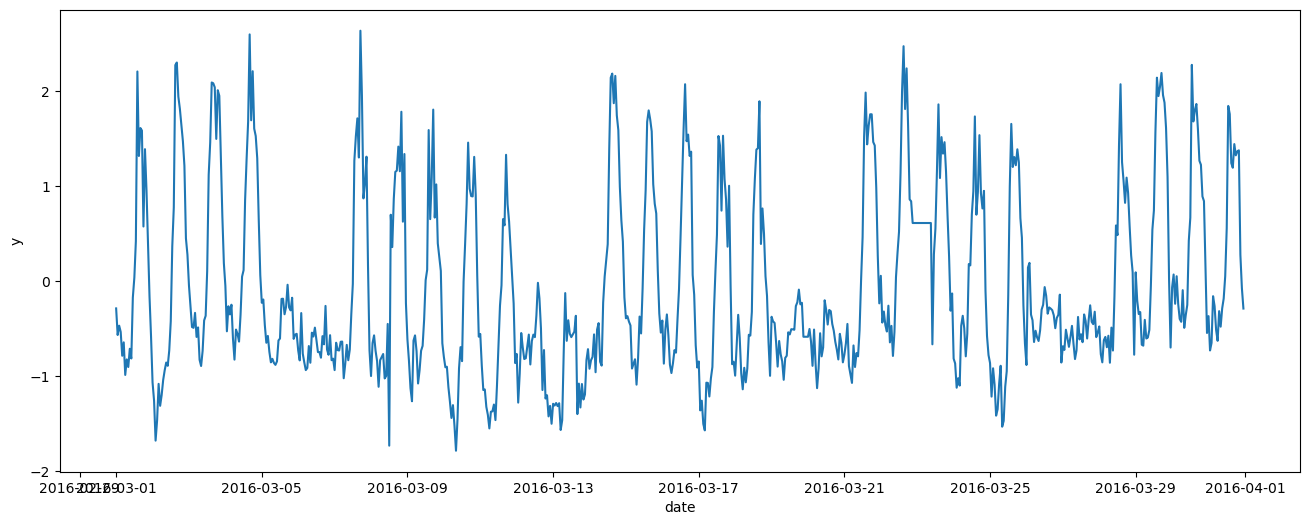

In [3]:
df = pd.read_csv("data/building_1298.csv", index_col=0, parse_dates=True)

df["weekday"] = df.index.weekday
df["hour"] = df.index.hour
df["t"] = np.arange(len(df))
df['hour_of_the_week'] = df.index.dayofweek * 24 + (df.index.hour + 1)

df.drop(df[df.m0 < 300].index, inplace=True)
df = df.assign(y= (df["m0"] - np.mean(df["m0"])) / np.std(df["m0"]))

df_train = df.loc['2016-03-01':'2016-03-31']
df_test = df.loc['2016-04-01':'2016-04-30']
df_all = pd.concat([df_train, df_test])

_, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_train.index, df_train['y'])
ax.set_xlabel("date")
ax.set_ylabel("y")

The model below is inspired from the [Mauna Loa CO2 example](https://locie.github.io/pySIP/examples/gaussian_process/Mauna_Loa_CO2.html) in the pySIP documentation.

We model the electricity consumption as the addition of a weekly periodic component (kernel k3) and a Matern long-term trend (kernel k1). Optionally, the periodic component could be further decomposed with a daily component (kernel k2), which is not used here.

In [4]:
df_train["datetime"] = df_train.index
df_train.set_index("t", inplace=True)

# Matérn 5/2 for long-term effects
p1 = [
    dict(name="mscale1", value=0.1, bounds=(0, None)),
    dict(name="lscale1", value=28, bounds=(0, None)),
    dict(name="sigv1", value=0.7, bounds=(0, None)),
]

# Periodic * Periodic
#p2 = [
#    dict(name="period2", value=24),
#    dict(name="mscale2", value=0.9, bounds=(0, None)),
#    dict(name="lscale2", value=1.4, bounds=(0, None)),
#    dict(name="sigv2", value=0.7, bounds=(0, None)),
#]

# ATTENTION lscale must have a lower bound
p3 = [
    dict(name="period3", value=24*7),
    dict(name="mscale3", value=0.9, bounds=(0, None)),
    dict(name="lscale3", value=0.05, bounds=(0.04, None)),
    dict(name="sigv3", value=0.7, bounds=(0, None)),
]


k1 = Matern52(p1, name="k1")
#k2 = Periodic(p2, name="k2")
k3 = Periodic(p3, name="k3")

# Compose covariance function
K = k1 + k3

# Initialize the regressor
reg = Regressor(K, outputs="y")

/tmp/ipykernel_10701/1664767666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["datetime"] = df_train.index


Now that the model has been defined, we can sample from the prior to see if it is consistent with the data (prior predictive checking).

/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('t', 'states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'outputs'} appear more than once in dims=('t', 'outputs', 'outputs'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Text(164.22222222222223, 0.5, 'y')

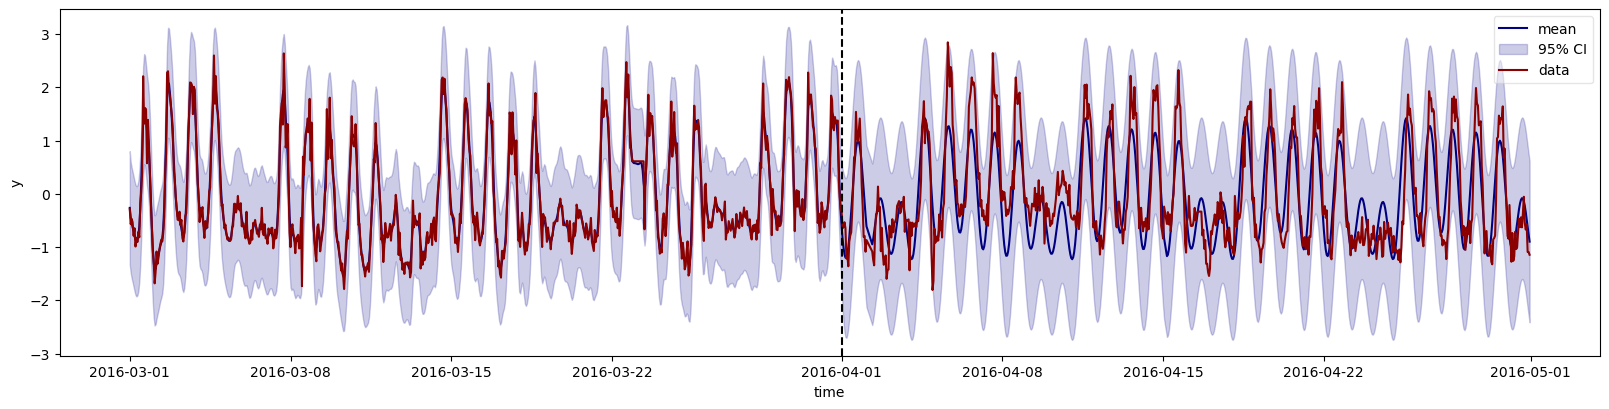

In [10]:
tnew = df_all["t"].values
ds = reg.predict(df=df_train, smooth=True, tnew=tnew)

# Plot output mean and 95% credible intervals
ym = ds["y_mean"].sel(outputs="y")
ysd = ds["y_std"].sel(outputs="y")

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_all.index, ym, color="navy", label="mean")
ax.fill_between(df_all.index, ym-2*ysd, ym+2*ysd, color="darkblue", alpha=0.2, label=r"95% CI")
ax.plot(df_all.index, df_all["y"], color="darkred", label="data")
ax.vlines(pd.Timestamp('2016-04-01'), 0, 1, transform=ax.get_xaxis_transform(), color='k', linestyles='dashed')
fig.tight_layout()
ax.legend(loc="best", fancybox=True, framealpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("y")

Model fitting denotes searching for optimal hyperparameters of the GP kernel functions.

In [7]:
fit_summary, corr_matrix, opt_summary = reg.fit(df=df_train)
fit_summary

Optimization terminated successfully.
         Current function value: 310.490861
         Iterations: 26
         Function evaluations: 540
         Gradient evaluations: 36


,θ,σ(θ),pvalue,|g(η)|,|dpen(θ)|
mscale1,0.487471,0.031868,0.000000,3.346517e-05,4.208255e-16
lscale1,3.247799,0.262399,0.000000,2.373526e-05,9.480291e-18
sigv1,0.239421,0.009333,0.000000,6.195571e-06,1.744521e-15
period3,167.698879,0.166752,0.000000,7.658186e-06,0.000000e+00
mscale3,1.643084,0.375013,0.000014,2.109760e-05,3.704079e-17
lscale3,0.040858,0.008736,0.000003,7.584815e-07,5.430685e+00
sigv3,0.700000,0.700000,0.317640,0.000000e+00,2.040816e-16


Posterior predictions, conditioned on observed training data:

/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('t', 'states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'outputs'} appear more than once in dims=('t', 'outputs', 'outputs'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most x

Text(164.22222222222223, 0.5, 'y')

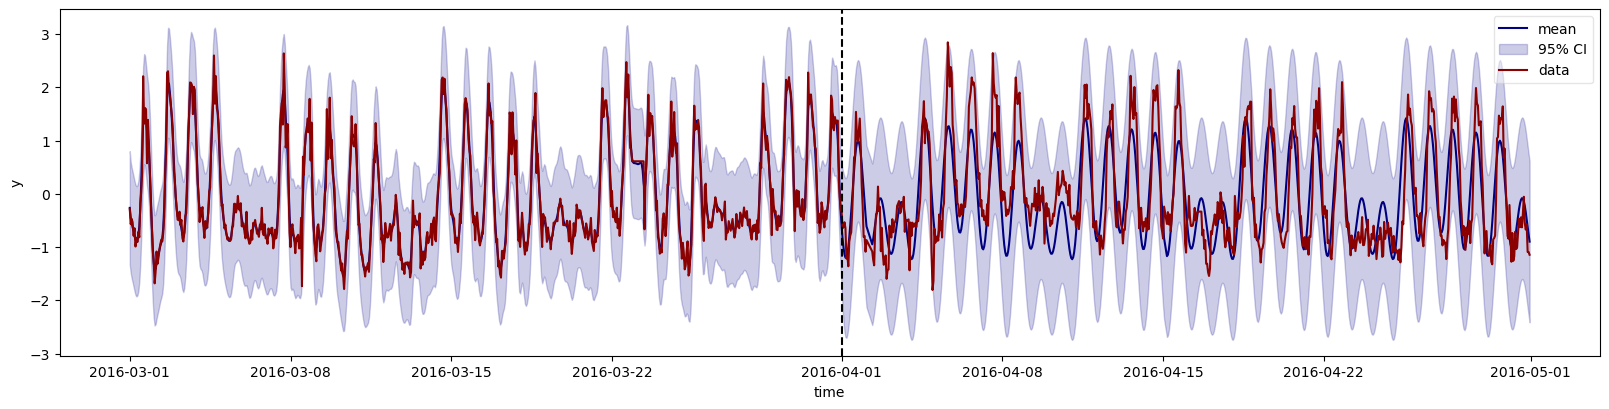

In [9]:
tnew = df_all["t"].values
ds = reg.predict(df=df_train, smooth=True, tnew=tnew)

# Plot output mean and 95% credible intervals
ym = ds["y_mean"].sel(outputs="y")
ysd = ds["y_std"].sel(outputs="y")

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(df_all.index, ym, color="navy", label="mean")
ax.fill_between(df_all.index, ym-2*ysd, ym+2*ysd, color="darkblue", alpha=0.2, label=r"95% CI")
ax.plot(df_all.index, df_all["y"], color="darkred", label="data")
ax.vlines(pd.Timestamp('2016-04-01'), 0, 1, transform=ax.get_xaxis_transform(), color='k', linestyles='dashed')
fig.tight_layout()
ax.legend(loc="best", fancybox=True, framealpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("y")